# Исследование окупаемости развлекательного приложения 

**Цель исследования:**

выявить причины убытков компании и найти точки роста.

**Задачи:**
* выяснить основные каналы привлечения пользователей и какими устройствами они пользуются;
* определить сколько стоит привлечение пользователей из различных рекламных каналов;
* рассчитать сколько денег приносит каждый клиент,
* выяснить когда расходы на привлечение клиента окупаются и 
* какие факторы мешают привлечению клиентов.

**Данные**

Для исследования доступны данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, 
orders_info_short.csv — информацию о заказах, 
а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.


In [1]:
#импортируем нужные библиотеки 
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Загрузка и ознокомление с данными

#### Загрузка файлов

In [2]:
#загрузим информацию 
visits = pd.read_csv('/datasets/visits_info_short.csv') # о посещениях сайта
orders = pd.read_csv('/datasets/orders_info_short.csv') #  о заказах
costs_ad = pd.read_csv('/datasets/costs_info_short.csv') # о расходах на рекламу

#### Ознакомимся с информацией в файлах

##### Визиты

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
# проверим соответствует ли временной интервал условию проекта
print('Минимальная дата:', pd.to_datetime(visits['Session Start']).min())
print('Максимальная дата начала сессии:', visits['Session Start'].max())
print('Максимальная дата конца сессии:', visits['Session End'].max())

Минимальная дата: 2019-05-01 00:00:41
Максимальная дата начала сессии: 2019-10-31 23:59:23
Максимальная дата конца сессии: 2019-11-01 01:38:46


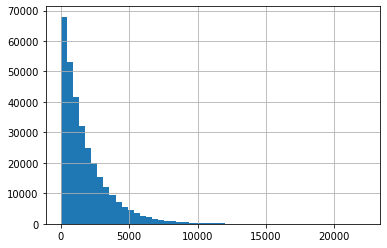

In [6]:
#  посмотрим на продолжительность сессий
duration = (pd.to_datetime(visits['Session End']) - pd.to_datetime(visits['Session Start'])).dt.seconds
duration.hist(bins=50);

In [7]:
(duration/60).describe()

count    309901.000000
mean         30.001514
std          30.051059
min           0.000000
25%           8.616667
50%          20.733333
75%          41.616667
max         370.950000
dtype: float64

**Наблюдения**

Пропусков нет. Проверить на наличие дубликатов.
Изменить тип данных в 'session_start' и 'session_end'. 
Неудобные названия столбцов.

В данных присутствуют аномально длинные пользовательские сессии - 370.95 минут. Но возможно это нормально для развлекательного приложения. Медианная продолжительность сессии - 20.7 минут.

##### Заказы

In [8]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
# посмотрим на основные описательные статистики суммы заказа 
orders['Revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: Revenue, dtype: float64

Подозрительное максимальное значение. 

In [11]:
orders.query('Revenue > 40')

,User Id,Event Dt,Revenue
207,696998937855,2019-05-07 01:32:00,49.99
244,423175451214,2019-05-08 15:58:19,49.99
667,698825366282,2019-05-14 20:39:52,49.99
862,243524410124,2019-05-17 23:29:54,49.99
1021,752744133703,2019-05-19 11:38:40,49.99
...,...,...,...
39058,75914663007,2019-10-20 17:33:37,49.99
39067,610997074195,2019-10-20 02:53:44,49.99
39324,470751600769,2019-10-23 07:20:55,49.99
39481,387107442792,2019-10-24 22:42:12,49.99


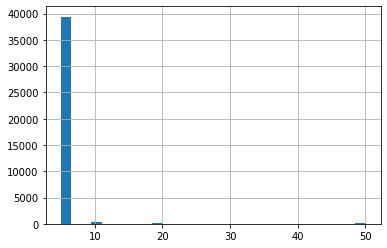

In [12]:
orders['Revenue'].hist(bins=30);

In [13]:
print('Минимальная дата заказа:', orders['Event Dt'].min())
print('Максимальная дата заказа:', orders['Event Dt'].max())

Минимальная дата заказа: 2019-05-01 00:28:11
Максимальная дата заказа: 2019-10-31 23:56:56


**Наблюдения**

Пропусков нет. Проверить на наличие дубликатов. Изменить тип данных в 'event_dt'. Также неудобные названия столбцов.

Основная масса заказов была на сумму менее 10 долларов, но есть и более крупные заказы, хоть их и не очень большое кол-во.

##### Расходы на рекламму

In [14]:
costs_ad.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [15]:
costs_ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [16]:
costs_ad['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

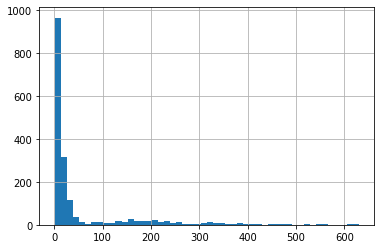

In [17]:
costs_ad['costs'].hist(bins=50);

In [18]:
print('Минимальная дата рекламной компании:', costs_ad['dt'].min())
print('Максимальная дата рекламной компании:', costs_ad['dt'].max())

Минимальная дата рекламной компании: 2019-05-01
Максимальная дата рекламной компании: 2019-10-27


**Наблюдения**

Также нет пропусков, нужно изменить тип данных в столбце 'dt' и проверить на наличие дубликатов.
Привести к нижнему регистру название столбца Channel. 

Расходы на рекламные компании варьируются в широких пределах. От 0.8 доллара до 630, но основная часть компаний стоила в пределах 50 долларов за компанию. 

### Предобработка данных

#### Редактируем название столбцов 

In [19]:
# изменим название столбцов для более удобной работы 
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits.head(2)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35


In [20]:
# изменим название столбцов 
orders.columns = ['user_id', 'event_dt', 'revenue']
orders.head(2)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99


In [21]:
# приведём название столбцов к нижнему регистру
costs_ad.columns = costs_ad.columns.str.lower()
costs_ad.head(2)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1


#### Тип данных

In [22]:
# преобразуем данные о времени 
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs_ad['dt'] = pd.to_datetime(costs_ad['dt']).dt.date

#### Проверка на наличие дубликатов

**1) Визиты**

In [23]:
# проверим на наличие явных дубликатов
visits.duplicated().sum()

0

In [24]:
# рассмотрим уникальные значения в столбцах 'region', 'device' и 'channel',
# чтобы проверить есть ли неявные дубликаты в данных 
display(visits['region'].unique())
display(visits['device'].unique())
visits['channel'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

**2) Заказы**

In [25]:
# проверим на наличие явных дубликатов
orders.duplicated().sum()

0

**3) Расходы на рекламу**

In [26]:
# проверим на наличие явных дубликатов
costs_ad.duplicated().sum()

0

In [27]:
costs_ad['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

**Наблюдения**

Дубликатов в данных не было выявлено. 

#### Проверка сессий

In [28]:
# проверим на соттветстиве начало и конец сессий 
visits.query('session_end < session_start')

,user_id,region,device,channel,session_start,session_end


In [29]:
# проверим есть ли ошибочные сессии 
visits.query('session_end == session_start')

,user_id,region,device,channel,session_start,session_end
100,172991619815,United States,Android,organic,2019-05-01 23:30:20,2019-05-01 23:30:20
396,70966634103,United States,iPhone,FaceBoom,2019-05-01 10:09:06,2019-05-01 10:09:06
6418,237822984474,United States,iPhone,FaceBoom,2019-05-08 11:44:29,2019-05-08 11:44:29
7658,691394091917,United States,iPhone,organic,2019-05-09 19:23:10,2019-05-09 19:23:10
8549,851693391616,United States,PC,TipTop,2019-05-10 03:28:02,2019-05-10 03:28:02
...,...,...,...,...,...,...
298392,869320035302,France,Mac,AdNonSense,2019-10-11 17:58:06,2019-10-11 17:58:06
300057,170196678386,France,PC,organic,2019-10-14 10:32:08,2019-10-14 10:32:08
302612,14571051192,Germany,iPhone,LeapBob,2019-10-18 13:33:12,2019-10-18 13:33:12
302852,716198028632,UK,Android,OppleCreativeMedia,2019-10-19 00:07:45,2019-10-19 00:07:45


### Выводы по разделам 1 и 2

В данных не было выявлено ни пропусков, ни дубликатов. 

Медианное значение стоимости заказов - 4.99 доллара. Основная масса заказов не превышает 5 долларов, но есть небольшое кол-во дорогих заказов. Максимальная стоимость заказа - 49.99 долларов.

Затраты на рекламные компании варьируются в довольно широких пределах (стандартное отколонение 107.74 доллара). 

Для визитов и заказов данные доступны с 01.05.2019 по 31.10.2019, а для данных о рекламных компаниях с 01.05.2019 по 27.10.2019.

Средняя продолжительность пользовательской сессии - 30 минут. Но было выявлено небольшое кол-во "ошибочных" сессий продолжительность 0 минут и очень длинных сессий, до 370 минут. 

Для более удобной работы были заменены названия в столбцак во всех датафреймах. 


-------------------------------------------

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Были использованны функции из теоретических уроков Яндекс Практикума. Поскольку функции были написаны не мной, то не могу привести их код здесь.



#### Пользовательские профили

In [30]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

 

    return profiles

#### Функция для расчёта LTV и ROI

In [31]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

  

#### Функция для расчёта конверсии

In [32]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

   
    return result_raw, result_grouped, result_in_time 

#### Функция для подсчёта Retention Rate

In [33]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

   
    return result_raw, result_grouped, result_in_time 

#### Функция для сглаживания фрейма

In [34]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации LTV и ROI

In [35]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

   

#### Функция для визуализации конверсии

In [36]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

   

#### Функция для построения графика Retention Rate

In [37]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

   

-----------

### Исследовательский анализ данных

- Составьтим профили пользователей и оперделим минимальную и максимальную даты привлечения пользователей.
- Выясним из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. 
- Определим какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 

#### Профили пользователей

In [38]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs_ad)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


**Mинимальная и максимальная даты привлечения пользователей**

In [79]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [40]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

In [41]:
profiles.shape

(150008, 9)

**Выводы**

Всего 150.008 пользователй. 

* Минимальная дата привлечения 1 мая 2019.
* Максимальная - 27 октября 2019. 

Данные соответствуют периоду, указанному в ТЗ.


#### Распределение пользователей по странам

In [42]:
profiles.groupby('region')\
    .agg({'user_id': 'nunique', 'payer': 'mean'})\
    .sort_values(by='payer', ascending=False)\
    .rename(columns={'user_id': 'Кол-во пользователй', 'payer': 'Доля платящих пользователей'})\
    .style.format({'Доля платящих пользователей': '{:.2%}'})


,Кол-во пользователй,Доля платящих пользователей
region,,
United States,100002,6.90%
Germany,14981,4.11%
UK,17575,3.98%
France,17450,3.80%


**Выводы**

Пользователи приходят в приложение из
* США,
* Германии,
* Великобритании,
* Франции.

На США приходится больше всего платящих пользователей. Также больше всего пользователей из США.

Стоит отметить, что в целом доля платящих пользователей очень низкая для всех стран. Варьируется в пределах 3.7-6.9% от общего числа пользователей.

#### Какими устройствами пользуютя пользователи

In [43]:
profiles.groupby('device')\
    .agg({'user_id': 'nunique', 'payer': 'mean'})\
    .sort_values(by='user_id', ascending=False)\
    .rename(columns={'user_id': 'Кол-во пользователй', 'payer': 'Доля платящих пользователей'})\
    .style.format({'Доля платящих пользователей': '{:.2%}'})

,Кол-во пользователй,Доля платящих пользователей
device,,
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%
Mac,30042,6.36%


**Выводы**

Наибольшее кол-во пользователей заходит в приложение с iPhone, а наибольшая доля платящих среди обладателей Mac. 

#### Каналы привлечения

In [44]:
users_channel = profiles.groupby('channel')\
    .agg({'user_id': 'nunique', 'payer': 'mean'})\
    .sort_values(by='payer', ascending=False)\
    .rename(columns={'user_id': 'Кол-во пользователй', 'payer': 'Доля платящих пользователей'})\
    #.style.format({'Доля платящих пользователей': '{:.2%}'})

In [45]:
users_channel_2 = users_channel.copy()
users_channel_2.style.format({'Доля платящих пользователей': '{:.2%}'})

,Кол-во пользователй,Доля платящих пользователей
channel,,
FaceBoom,29144,12.20%
AdNonSense,3880,11.34%
lambdaMediaAds,2149,10.47%
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%


**Выводы**

Наибольшее кол-во пользователей пришло в приложение органическим путём. 

Среди рекламных каналов по кол-ву пользователей лидирует FaceBoom, за ним следует TipTop.

Больше всего платящих пользователей пришло из FaceBoom, AdNonSense и lambdaMediaAds. 

#### Общий вывод по разделу

Минимальная дата привлечения 1 мая 2019. Максимальная - 27 октября 2019.
За этот период приложением воспользовалось 150.008 пользователей.

Подавляющее большинство пользователей из США - 66,7%. Также приложением пользуются жители Германии, Франции и Великобритании.

Пользователи чаще всего использовали iPhone для захода в приложение. Однако, наибольшая доля платящих пользователей среди пользователей Мас. iPhone на втором месте. То есть можно сделать вывод, что пользователи Apple имеют лучшую конверсию в покупателей.

Также стоит отметить, что суммарно преобладают пользователи, которые заходят в приложение с мобильных устройств. 

37,6% пользователей пришло в приложение органическим путём, остальные через рекламные каналы. Всего было задействовано 10 каналов. Больше всего пользователей пришло через FaceBoom (19,4%). Среди пользователей пришедших через этот канал доля платящих пользователей наивысшая - 12,2%. В свою очередь среди органических пользователей доля платящих наименьшая - 2,1%.

На втором месте по кол-ву привлеченных пользователей - канал TipTop (13%). Остальные каналы привлекли от 1,4% до 5,7% пользователей.


------------------

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним как траты распределены по рекламным источникам (сколько денег потратили на каждый источник).
- Визуализируем динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Посчитаем сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.



#### Общая сумма расходов

In [46]:
print('Общая сумма расходов на маркетинг:', round(costs_ad['costs'].sum(), 2))

Общая сумма расходов на маркетинг: 105497.3


#### Распределение трат по рекламным источникам

In [47]:
costs_channel = costs_ad.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)\
                         .rename(columns={'costs': 'Затраты на рекламу, $'})

costs_channel['Доля от суммарных затрат,%'] = round(costs_channel['Затраты на рекламу, $']/(costs_ad['costs'].sum())*100, 2)

In [48]:
costs_channel

,"Затраты на рекламу, $","Доля от суммарных затрат,%"
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


**Выводы**

Больше всего было потрачено на TipTop, около 1/2 от общей суммы расходов. За ним следует FaceBoom и, с большим отрывом, WahooNetBanner.

####  Динамика изменения расходов во времени (по неделям и месяцам)

In [49]:
# добавим столбецы с неделями и мясяцами в датафрейм расходов на рекламу
costs_ad['dt'] = pd.to_datetime(costs_ad['dt'])

costs_ad['week'] = costs_ad['dt'].dt.isocalendar().week
costs_ad['week_p'] = costs_ad['dt'].dt.to_period("W")

costs_ad['month_p'] = costs_ad['dt'].dt.to_period("M")

**1) Недельные расходы**

In [50]:
# подготовим данные для визуализации 1 - сгруппируем расходы по неделе и посчитаем общую сумму расходов по всем каналам
costs_week_total = costs_ad.pivot_table(
    index='week_p', values='costs', aggfunc='sum'
)

#costs_week_total.head()

In [51]:
# подготовим данные для визуализации 2 - сгруппируем расходы по неделе и каналу привлечения, 
# посчитаем сумму расходов за неделю
costs_channel_week = costs_ad.pivot_table(
    index='week_p', columns='channel', values='costs', aggfunc='sum'
)
costs_channel_week.head(3)

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
week_p,,,,,,,,,,
2019-04-29/2019-05-05,211.05,535.7,16.80,38.64,24.0,99.45,347.0,49.2,52.2,81.6
2019-05-06/2019-05-12,273.00,750.2,31.71,61.68,34.5,139.23,470.0,92.4,75.9,103.2
2019-05-13/2019-05-19,265.65,755.7,26.67,59.04,27.5,138.06,454.0,90.0,69.3,90.4


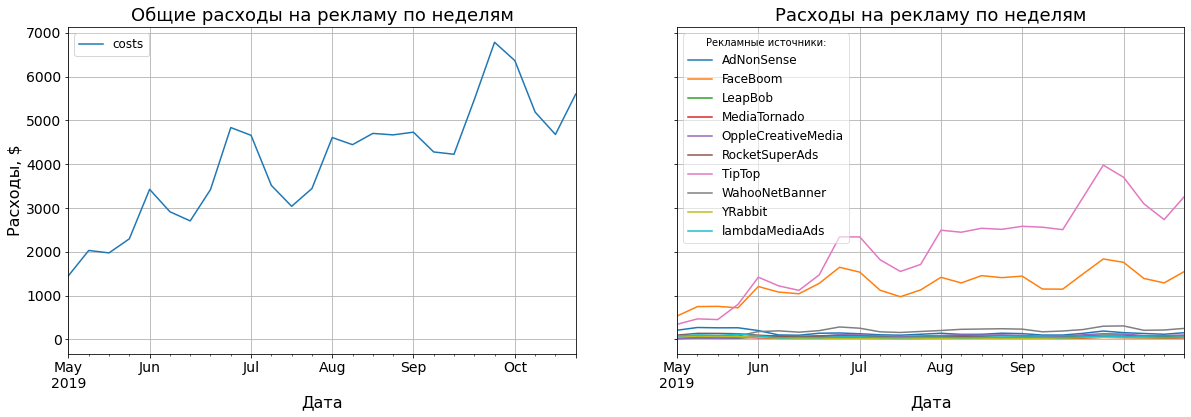

In [52]:
# построим графики

plt.figure(figsize=(20, 6))  # задаём размер сетки

# первый график — динамика изменения суммы расходов во времени
ax1 = plt.subplot(1, 2, 1)
costs_week_total.plot(grid=True, ax=ax1)
plt.legend(loc='upper left', fontsize='large')
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Расходы, $', fontsize=16)
plt.title('Общие расходы на рекламу по неделям', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# второй график — динамика изменения расходов по каналам привлечения
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
costs_channel_week.plot(grid=True, ax=ax2)
plt.legend(loc='upper left', fontsize='large', framealpha=0.6, title='Рекламные источники:')
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Расходы, $', fontsize=16)
plt.title('Расходы на рекламу по неделям', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show() ;

**Выводы**

За исследуемый период (май-октябрь 2019) основная тенденция - рост общих расходов на рекламу расходы, хоть и наблюдаются колебания трат от неделе к неделе. Если рассмотреть траты по каналам привлечения, то основной вклад в суммарные траты вносят каналы TipTop и FaceBoom - каналы-лидеры по кол-ву пользователей. FaceBoom также лидер по доле платящих пользователей. Траты на эти каналы растут в течение всего рассматриваемого периода. 

Траты на остальные рекламные источники практически не изменяются во времени и не превышают 500$ в неделю. 

**2) Месячные расходы**

In [53]:
# подготовим данные для визуализации 1 - сгруппируем расходы по месяцу и посчитаем общую сумму расходов по всем каналам
costs_month_total = costs_ad.pivot_table(
    index='month_p', values='costs', aggfunc='sum'
)

In [54]:
# подготовим данные для визуализации 2 - сгруппируем расходы по месяцу и каналу привлечения, 
# посчитаем сумму расходов за месяц
costs_channel_month = costs_ad.pivot_table(
    index='month_p', columns='channel', values='costs', aggfunc='sum'
)

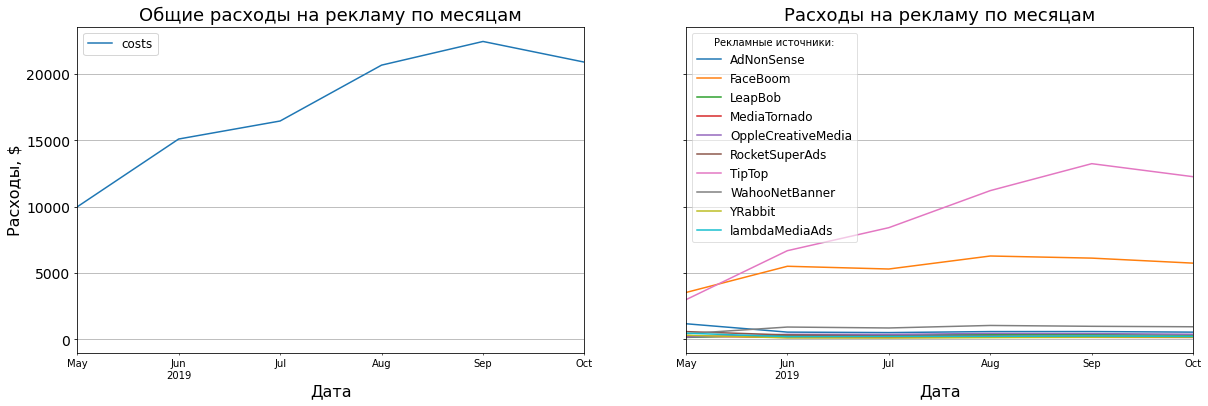

In [55]:
# построим графики

plt.figure(figsize=(20, 6))  # задаём размер сетки

# первый график — динамика изменения суммы расходов во времени
ax1 = plt.subplot(1, 2, 1)
costs_month_total.plot(grid=True, ax=ax1)
plt.legend(loc='upper left', fontsize='large')
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Расходы, $', fontsize=16)
plt.title('Общие расходы на рекламу по месяцам', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# второй график — динамика изменения расходов по каналам привлечения
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
costs_channel_month.plot(grid=True, ax=ax2)
plt.legend(loc='upper left', fontsize='large', framealpha=0.6, title='Рекламные источники:')
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Расходы, $', fontsize=16)
plt.title('Расходы на рекламу по месяцам', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show() ;

**Выводы**

По месячным расходам можно сделать аналогичные выводы: 
* рост общих расходов на рекламу, хотя с сентября наблюдается небольшое снижение расходов;
* TipTop и FaceBoom - каналы, на которые больше всего тратят средств;
* траты на остальные каналы значительно ниже и практически не изменяются от месяца к месяцу.

#### Средняя стоимость привлечения одного пользователя (CAC) из каждого источника

In [56]:
cost_mean = costs_channel.merge(users_channel, how='inner', on='channel')
cost_mean['cac, $'] = round(cost_mean['Затраты на рекламу, $']/cost_mean['Кол-во пользователй'], 2)

cost_mean.drop(['Доля платящих пользователей'], axis=1).sort_values(by='cac, $', ascending=False)

,"Затраты на рекламу, $","Доля от суммарных затрат,%",Кол-во пользователй,"cac, $"
channel,,,,
TipTop,54751.30,51.90,19561,2.80
FaceBoom,32445.60,30.75,29144,1.11
AdNonSense,3911.25,3.71,3880,1.01
lambdaMediaAds,1557.60,1.48,2149,0.72
WahooNetBanner,5151.00,4.88,8553,0.60
RocketSuperAds,1833.00,1.74,4448,0.41
OppleCreativeMedia,2151.25,2.04,8605,0.25
MediaTornado,954.48,0.90,4364,0.22
YRabbit,944.22,0.90,4312,0.22


In [57]:
print('Средний САС:', round(costs_ad['costs'].sum()/profiles.query('channel != "organic"').agg({'user_id': 'nunique'}), 2));

Средний САС: user_id    1.13
dtype: float64


In [58]:
print('Средний САС:', round(cost_mean['Затраты на рекламу, $'].sum()/cost_mean['Кол-во пользователй'].sum(),2))

Средний САС: 1.13


In [59]:
profiles.query('channel != "organic"')['acquisition_cost'].mean()

1.1274813239427588

**Выводы**

У источника TipTop наивысшая стоимость привлечения одного пользователя, почти 3 доллара. За ним, с большим отрывом, следуют FaceBoom и AdNonSense. У этих двух источников средняя стоимость 1.1 доллара и 1 доллар соответственно. У остальных источников стоимость привлечения не превышает 0.8 доллара. 

Наименьшая стоимость привлечения у LeapBob - 0.2 доллара.

Отметим, что несмотря на то, что у канала TipTop наивысшая стоимость привлечения, доля платящих пользователей для этого канала не самая высокая (см. п.5.4). TipTop только на 4 месте. 


#### Общие выводы по разделу

На рекламные компании суммарно было потрачено 105497.3 долларов. 52% от этой суммы был потрачены на TipTop, a 31% на FaceBoom. На остальные рекламные каналы было потрачено значительно меньше. 

Расходы на TipTop и FaceBoom расли на протяжение всего периода, а тараты на остальные источники были стабильны во времени. 

В среднем на привлечение одного пользователя было потрачено 1.13 доллара. Наибольшие затраты на привлечение у канала TipTop - 2.8 доллара, наименшие у LeapBob - 0.21 доллара. 

----

### Окупаемость рекламы

Из ТЗ *"на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения"*. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.
- Проверим конверсию и удержание пользователей и динамику их изменения. 
- Проанализируем окупаемость рекламы с разбивкой по устройствам, по странам и по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

#### Окупаемость рекламы (LTV и ROI)

In [63]:
# Установим момент и горизонт анализа данных
observation_date = datetime(2019, 10, 27).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

**Основная цель исследования - разобраться почему при огромных вложениях в рекламу, компания терпит убытки. В связи с этим стоит сконцентрировать внимание на пользователях, пришедших по рекламе, и исключить органических пользователей из расчёта метрик.** 

In [64]:
# исключим органических пользователей из анализа
profiles = profiles.query('channel != "organic"')

In [65]:
# вызовим функцию для расчёта LTV
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

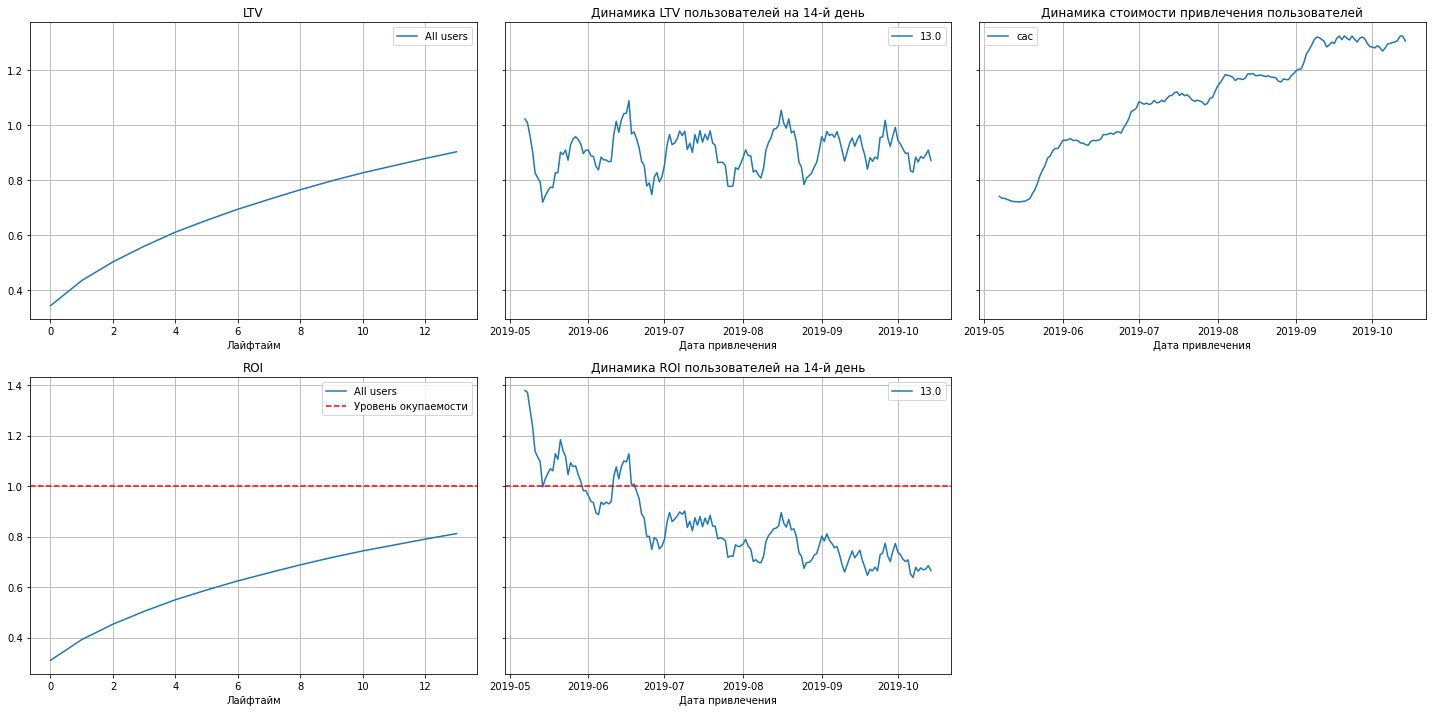

In [66]:
# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Выводы**

* Реклама не окупается. К концу второй недели ROI только приблизился к 80%.
* CAC стремительно увеличивается. При этом значения ROI на 14 день стремительно уменьшаются. Так, если до июля вложения в рекламу окупались, то после затраты на рекламу не окупались даже на 14 день.
* Динамика LTV циклична. В целом, к серидине месяца наблюдается рост, а к концу месяца - спад. Но на протяжение исследуемого периода LTV поддерживалось на одном уровне, изменяясь в диапазоне  от 0.6 до 0.8 долларов. То есть, качество пользователей стабильно.

Скорее всего основная причина неокупаемости - рост стоимости привлечения покупателей. 

#### Конверсия пользователей и динамика её изменения

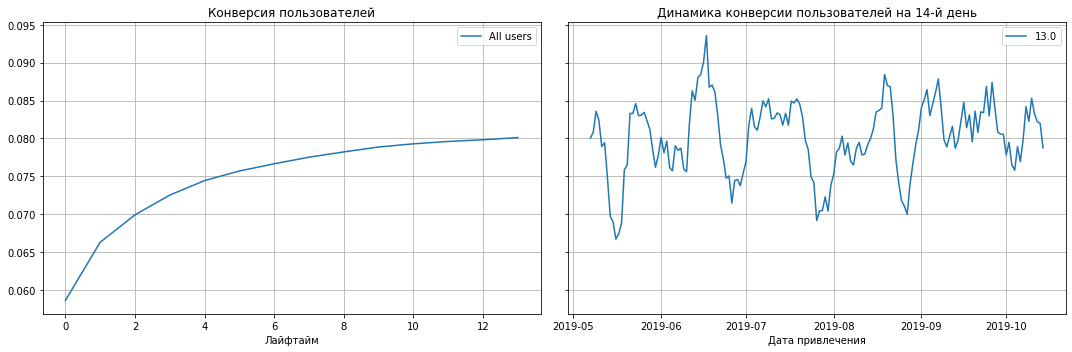

In [67]:
# вызовим ф-ю для подсчёта конверсии 
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=[]
)

# построим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Выводы**

* Конверися постепенно увеличивается. К концу второй недели около 80% пользователей становятся платящими.
* Динамика конверсии схожа с динамикой LTV, также наблюдается цикличность, но нет такой чёткой привязонности пиков и спадов ко времени.


#### Удержание пользователей

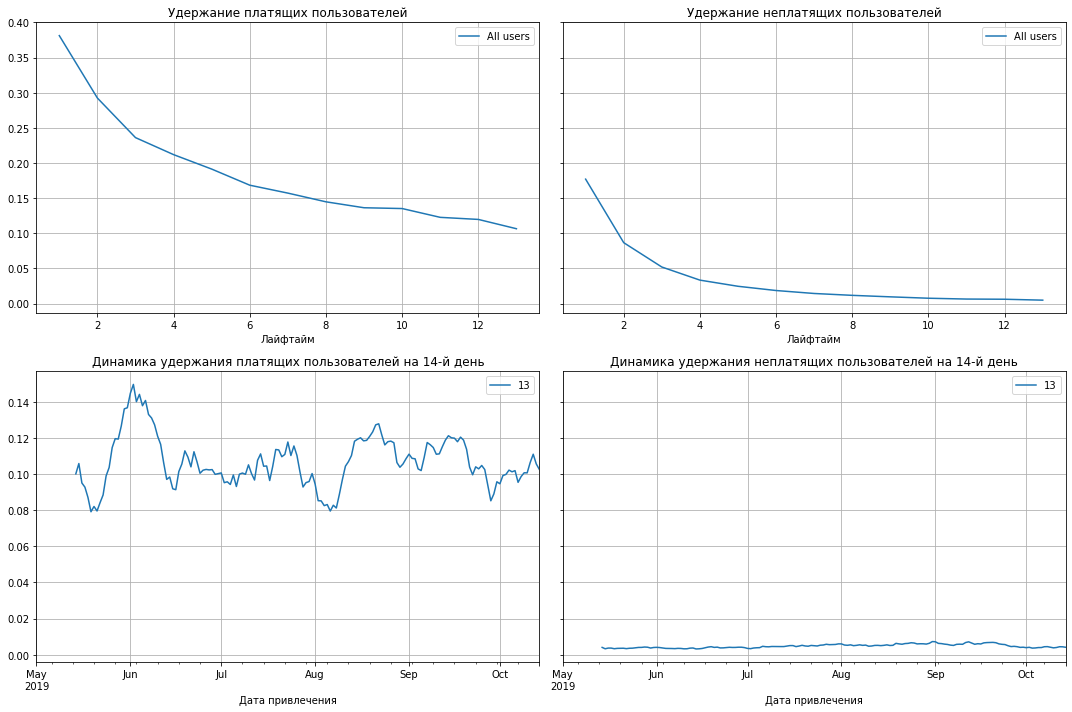

In [68]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=[]
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводвы**

Платящие пользователи удерживаются лучще, чем не платящие. Динамика удержания платящих пользователей варьируется в течение исследуемого периода, но не опускается ниже 8%. Динамика удержания неплатящих пользователей практически неизменна.

#### Окупаемость рекламы с разбивкой по устройствам

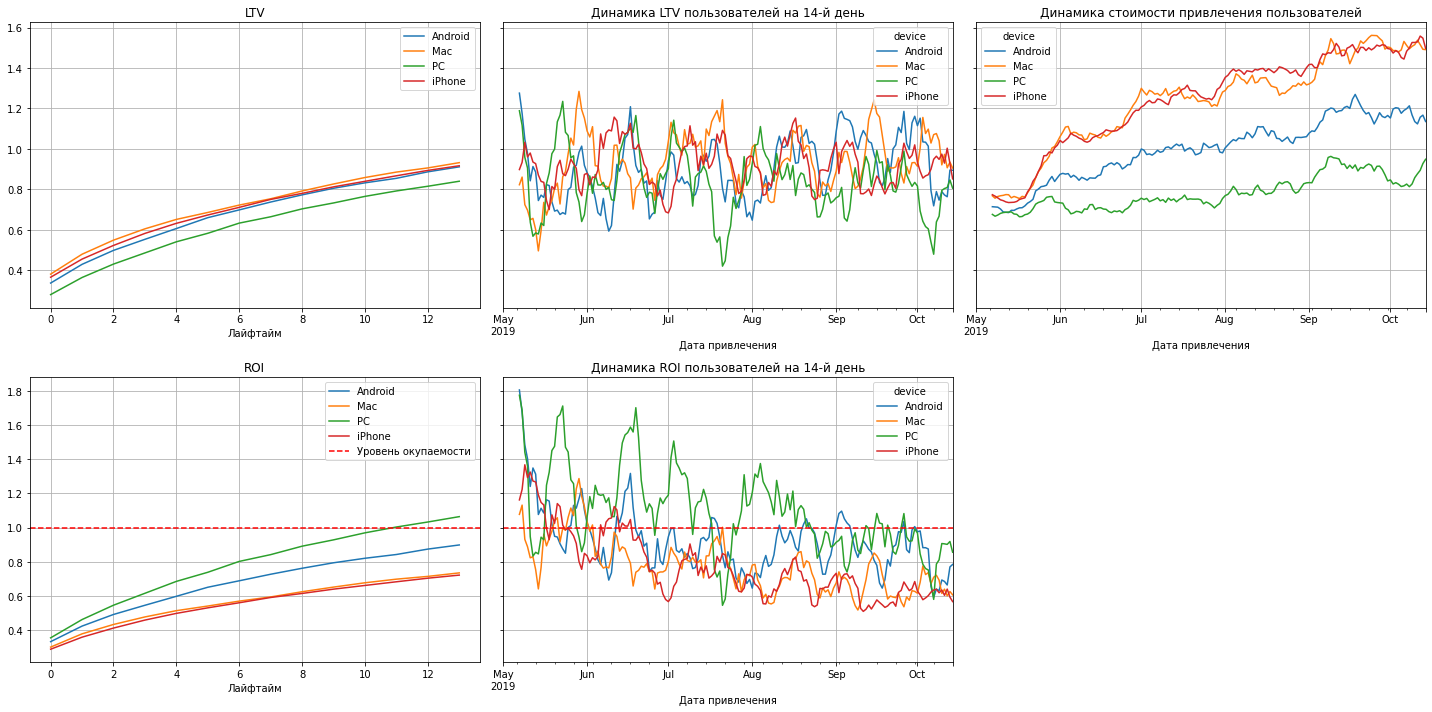

In [69]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

# вызовим функцию для расчёта LTV
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

In [70]:
ltv_grouped.sort_values(by=13)

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,
PC,17612,0.280144,0.364705,0.431014,0.486162,0.541141,0.583244,0.633465,0.664801,0.703856,0.733098,0.765569,0.792430,0.815663,0.840429
Android,20092,0.337223,0.429726,0.498728,0.553369,0.606625,0.660433,0.698736,0.737634,0.773107,0.805696,0.832519,0.854872,0.886967,0.911556
iPhone,31171,0.366081,0.455614,0.523240,0.582642,0.632405,0.673612,0.711335,0.750626,0.780534,0.812619,0.840059,0.867370,0.894015,0.916941
Mac,17263,0.381329,0.479749,0.549301,0.605217,0.651763,0.686161,0.722642,0.753689,0.792261,0.826778,0.858808,0.885691,0.906217,0.932290


**Выводы**

* «Пожизненная ценность» клиента ниже для пользователей РС, чем для пользователей других устройств. Выше всего LTV у пользователей Mac.
* Реклама не окупается совсем для пользователей iPhone, Mac и Android. Для пользователей РС реклама начинает окупаться только на 12 день жизни. 
* CAC стремительно увеличивается для всех устройст. Наиболее стремительно растёт стоимость привлечения пользователей iPhone и Mac. При этом значения ROI уменьшаются. До середины июня вложения в рекламу переодически окупались для пользователей всех устройств, однако после затраты на рекламу окупались только для пользователей РС и иногда для пользователей Android.
* Динамика LTV также циклична, существенных различий между пользователями различных устройст нет. 

Стоит рассмотреть пользователей iPhone и Mac подробнее.

#### Окупаемость рекламы с разбивкой по странам

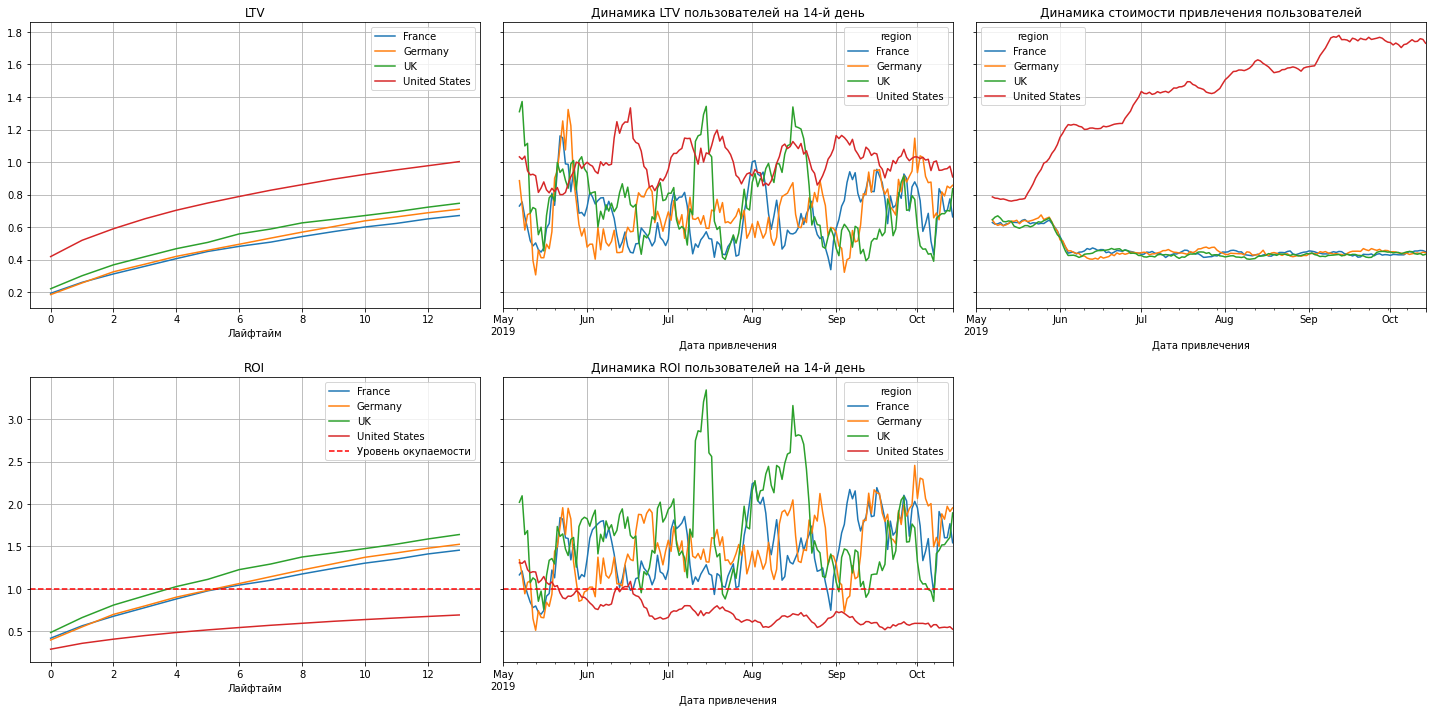

In [71]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

# вызовим функцию для расчёта LTV
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Выводы**

«Пожизненная ценность» клиента выше всего для пользователей из США, но при этом они же и самые дорогие пользователи. Траты на их привлечение стреимтельно растут, притом, что затраты на привлечение пользователей из других регионов практически не изменяются на протяжении всего исследуемого периоды. 
Также пользователи из США единственные, затраты на чьё привлечение не окупаются. 

#### Окупаемость рекламы с разбивкой по рекламным каналам

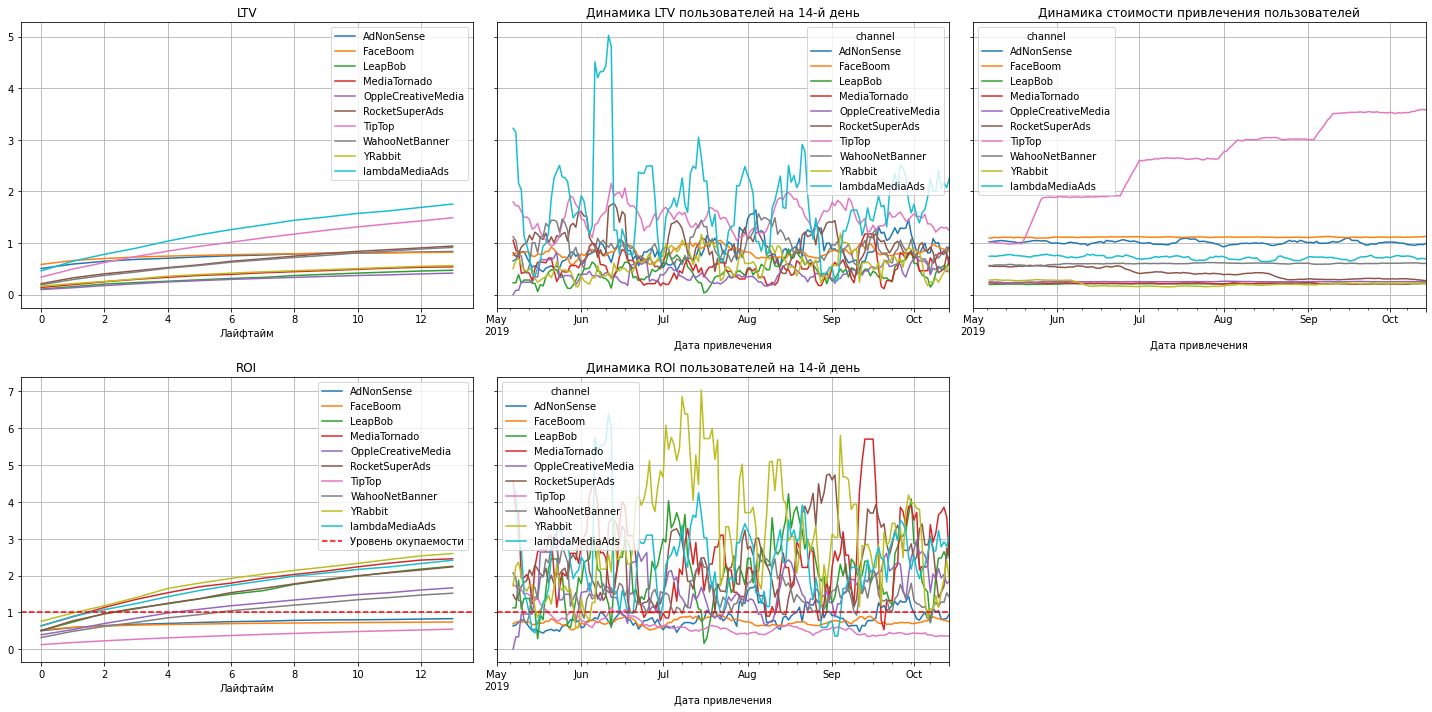

In [72]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

# вызовим функцию для расчёта LTV
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
# в этом случае делала window = 14 в функции для визуализации, чтобы сгладить сильнее "шум"
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

In [73]:
roi_grouped.sort_values(by=13)

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
TipTop,17953,2.733487,0.124107,0.181281,0.227717,0.270309,0.308344,0.342514,0.371273,0.401762,0.429099,0.456211,0.480249,0.502173,0.522736,0.545250
FaceBoom,26736,1.113659,0.525497,0.593113,0.628178,0.653688,0.670115,0.682183,0.695121,0.704409,0.711147,0.718724,0.723618,0.729149,0.733844,0.737531
AdNonSense,3627,1.008023,0.501816,0.586992,0.641588,0.677074,0.699185,0.725399,0.747236,0.760885,0.782730,0.795014,0.798017,0.806206,0.818490,0.829417
WahooNetBanner,7832,0.601685,0.316444,0.485073,0.619988,0.729062,0.851269,0.939375,1.044277,1.121577,1.197193,1.266026,1.342479,1.402415,1.470194,1.520177
OppleCreativeMedia,7890,0.249905,0.391262,0.533004,0.698562,0.840299,0.982574,1.083804,1.179977,1.257421,1.335920,1.411847,1.483215,1.534338,1.607775,1.665982
RocketSuperAds,4142,0.420648,0.503574,0.771704,0.957864,1.101063,1.246558,1.373148,1.536453,1.651018,1.774795,1.896259,1.994209,2.074406,2.152308,2.238228
LeapBob,7875,0.209947,0.509553,0.735933,0.971349,1.114418,1.233335,1.366140,1.493507,1.587681,1.759830,1.874520,1.986198,2.085803,2.176347,2.251801
lambdaMediaAds,2012,0.726839,0.633445,0.890174,1.074432,1.238984,1.426723,1.593928,1.733828,1.856667,1.983609,2.068914,2.165823,2.234067,2.326217,2.414941
MediaTornado,4081,0.219005,0.635417,0.882206,1.134578,1.352421,1.532302,1.694224,1.794721,1.928728,2.029247,2.124161,2.235835,2.336332,2.420079,2.454708


**Выводы**

* Наиболее высокая «Пожизненная ценность» у клиентов пришедших через канал lambdaMediaAds. 
* Затраты на каналы TipTop, FaceBoom и AdNonSense не окупаются. При этом стоимость привлечения через канал TipTop расла на протяжение всего исследуемого периода.
* Траты на YRabbit окупаются лушче всего.  

**Раасотрим удержание в разбивке по регионам и по каналам привлечения**

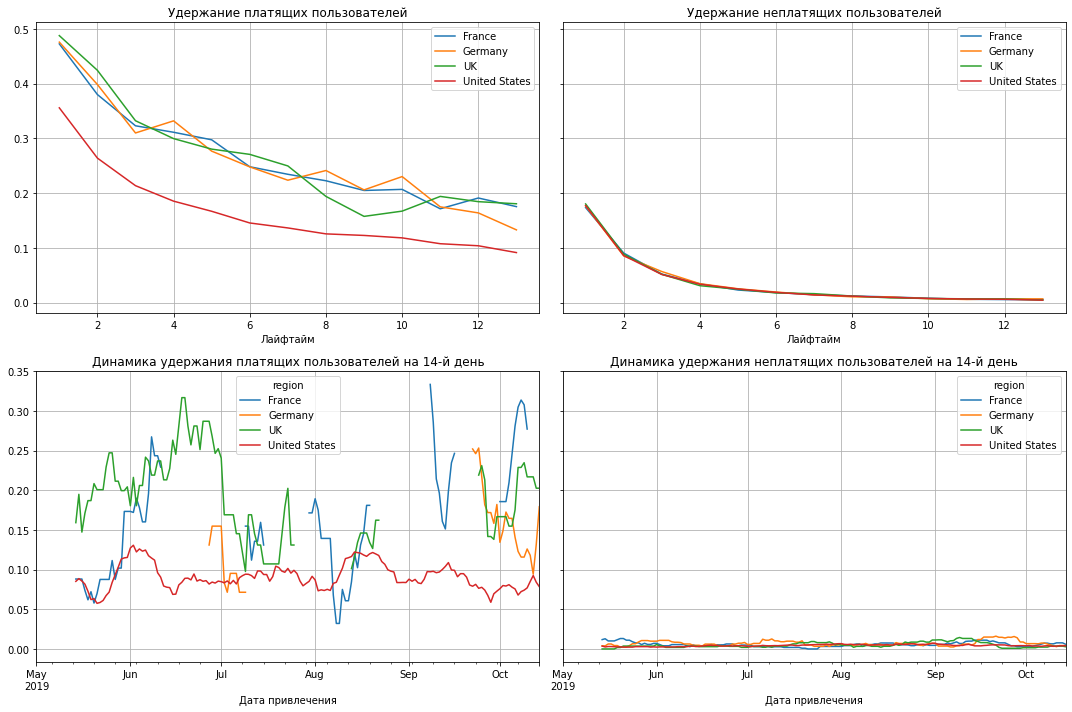

In [74]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

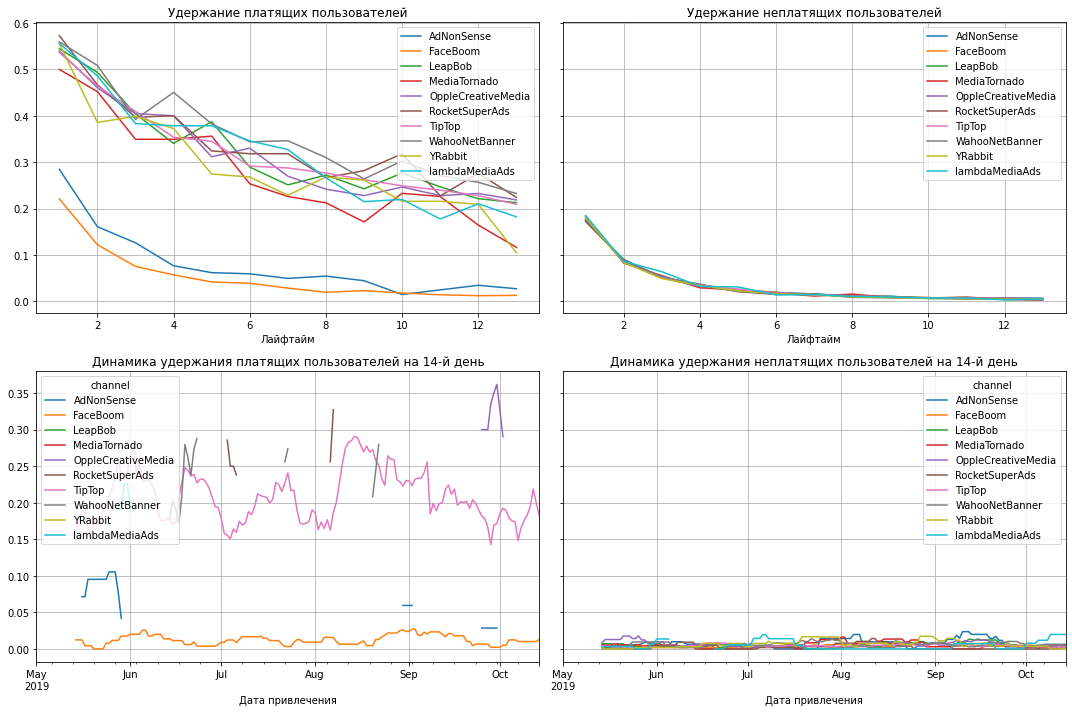

In [75]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

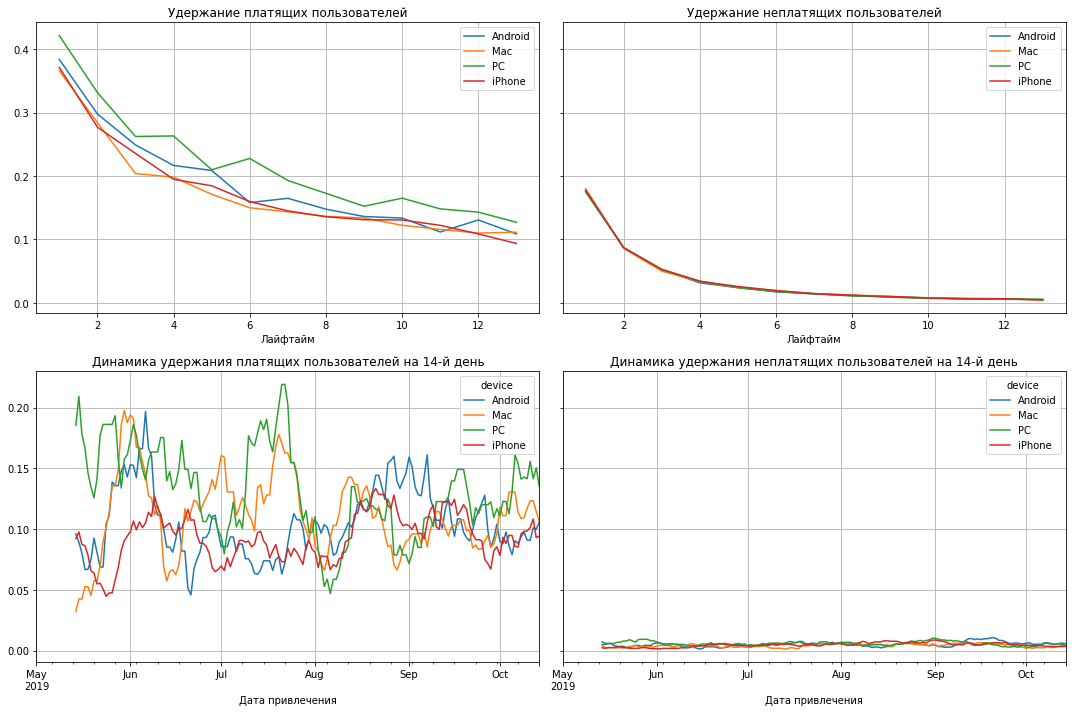

In [76]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Выводы**

Среди неплатящих пользователй различий в удержании в разбивках по региону, устройству и каналу привлечения не наблюдается, а вот среди платящих различия есть:
* хуже всего удерживаются пользователи из США,
* а также пользователи, пришедшие через каналы FaceBoom и AdNonSense.
* Что касается устройств, то лучше всего удерживаются пользователи РС. 

#### Общие выводы по разделу

По итогам исследования метрик, были выявлены проблемы с несколькими рекламными каналами (TipTop, FaceBoom и AdNonSense), а также проблемы с удержанием и окупаемостью пользователей из США - основной аудитории приложения. 
Технических проблем, влияющих на монетизацию, скорее всего нет, но стоит подробнее рассмотреть пользователей Мас и iPhone, так как они удерживаются несколько хуже, чем пользователи РС и Android. 



**Окупается ли реклама, направленная на привлечение пользователей в целом?**
В целом реклама не окупается. 

**Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?**
Негативное влияние на окупаемость могут оказывать пользователи iPhone и Mac, пользователи из США и использование для привлечения клиентов каналов TipTop, FaceBoom и AdNonSense. 

**Чем могут быть вызваны проблемы окупаемости?**
В данном случае можно выделить несколько прични:
1) Технические.

Возможно у пользователей iPhone и Mac возникают какие-то технические проблемы при использовании приложения. Пользователи этих устройств удерживаются несколько хуже, чем пользователи Android и РС. При этом затраты на привлечение пользователей iPhone и Mac значительно выше, чем на привлечение пользователей других устройств.

2) Проблемы в удержании пользователей.

Пользователи из США приносят больше всего прибыли (самые высокие значения LTV), но при этом они хуже всего удерживаются, а затраты на привлечение очень высокие.

3) Неудачный выбор рекламных каналов.

Во-первых, тут можно выделить каналы, из которых пришли "некачественные" пользователи, которы плохо удерживаются - это FaceBoom и AdNonSense, при это самые дорогие каналы привлечения после TipTop.
Во-вторых, использование очень дорогих каналов  как TipTop. Несмотря на то, что пользователи, причедшие через этот канал, имеют высокую "пожизненную ценность" (на втором месте после пользователей пришедших из lambdaMediaAds), затраты на их привлечение не окупаются. 


### Общие выводы



Клиентами приложения являются пользователи из США, Германии, Великобритании и Франции. Подавляющее большинство пользователей из США (100.002 из 150.008). Также доля платящих пользователей наивысшая в США, хотя стоит отметить, что в целом доля платящих пользователей невысокая и варьируется от страны к стране в пределах 3.8-6.9%.

Наибольшее кол-во пользователей используют iPhone (54479 человек), за ним  по популярности следует Android (35032). РС и Мас используют примерно одинаковое кол-во пользователей (30455 и 30042). Для платящих пользователей наиболее высокая среди пользователей Мас. 
38% пользователей пришли органическим путём, а остальные были привлечены через различные рекламные каналы. Всего было задействовано 10 каналов.  
Средняя стоимость привлечения варьируется в зависимости от каналы. Наименьшая составляет 0.21 доллара (канал LeapBob), а наивысшая 2.79 (канал TipTop). 

Для исследования окупаемости были отобраны пользователи пришедшие через рекламные каналы и отсеяны органические пользователи. Далее пойдёт речь о пользователях, пришедших через рекламу.
В среднем такие клиенты приносят около 0.9 доллара к концу второй недели жизни, но затраты на их привлечения не окупаются. К концу исследуемого траты на рекламу превысили 1.2 доллара на человека. 
При рассмотрении метрик по устройствам, регионам и канал привлечения, было выявлено, что:
* Окупаются только пользователи, использующие РС, а пользователи, использующие Android, iPhone и Мас не окупаются, хотя «пожизненная ценность» у этих пользователей выше, чем у тех, кто использует РС. Также удержание у этих трех групп пользователей хуже, а затраты на их привлечение выше, чем на привлечение пользователей РС.
* Пользователи из США не окупаются несмотря на то, что их LTV значительно выше, чем у пользователей из других стран.  В то время как затраты на привлечение пользователей из Германии, Франции и Великобритании поддерживались практически на одном уровне в течение всего исследуемого периоды, затраты на привлечение пользователей из США выросли с 1 доллара до 3.5. При этом платящие пользователи из США удерживались хуже всего, к концу второй недели только 10% продолжали использовать приложение. 
* Что касается рекламных каналов, то затраты на привлечение пользователей через TipTop, FaceBoom и AdNonSense не окупились. Также пользователи, пришедшие через FaceBoom и AdNonSense, удерживались значительно хуже, чем пришедшие из других каналов.  А вот хорошо себя показали каналы YRabbit и lambdaMediaAds. У первого наилучшая окупаемость, а через второй удалось привлечь пользователей с наивысшей «пожизненной ценностью».

Одна из основных причин неэффективности привлечения пользователей – неудачное распределение рекламного бюджеты. 
Рекомендации для отдела маркетинга:
- 1) Отказаться от использования канала TipTop. Это самый дорогостоящий канал, и несмотря на то, что он приносит клиентов с высокой «пожизненной ценностью»,  затраты на его использование не окупаются.
- 2) Также стоит отказаться от использования FaceBoom и AdNonSense. Также два дорогих канала, которые не окупаются и приносят клиентов, которые плохо удерживаются. 
- 3) Обратить внимание на канал lambdaMediaAds, поскольку он окупается и приносит «качественных» клиентов, с высокими LTV.
- 4) Пересмотреть стратегию удержания для клиентов из США. Они составляют основную долю от всех пользователей и имеют высокую «пожизненную ценность», но при этом плохо удерживаются, а затраты на их привлечение растут очень сильно. 
- 5) Проверить есть ли технические проблемы у пользователей  iPhone и Mac , клиенты, использующие эти устройства хуже удерживаются, а траты на их привлечение не окупаются. 
- 6) Обратить внимание на пользователей, использующих РС. При относительно не высоком LTV, траты на привлечение этих пользователей окупаются. 
- 7) Увеличить конверсию пользователей. 

